In [4]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from block_ai.lib.myblokus.piece import Piece
from block_ai.lib.myblokus.point import Point
from block_ai.lib.myblokus.orientation import Orientation
from sklearn.preprocessing import normalize
from block_ai.lib.myblokus import point
import logging

logging.basicConfig(level=logging.DEBUG)

## Visualization

In [5]:
class PieceVisualization:
    EMPTY = 0
    FULL = 1
    BORDER = 2
    PLAYABLE = 3
    START = 4
    
    def __init__(self):
        pass
    
    def fill(self, point, value):
        x, y = self.get_indices(point)
        self.matrix[x, y] = value
        
    def get_indices(self, point):
        return point.x + 5, point.y + 5
    
    def display(self, orientation):
        self.init_matrix()
        self.fill_in_points(orientation)
        self.gen_graph()

    def init_matrix(self):
        self.x = [str(x) for x in range(-5, 6)]
        self.y = [str(x) for x in range(-5, 6)]
        matrix = []
        for x in self.x:
            sub = [self.EMPTY for y in self.y]
            matrix.append(sub)
        self.matrix = np.matrix(matrix)

    def fill_in_points(self, orientation):
        for p in orientation.points:
            self.fill(p, self.FULL)

        for p in orientation.get_corner_points():
            self.fill(p, self.PLAYABLE)
        
        for p in orientation.get_border_points():
            self.fill(p, self.BORDER)
            
        self.fill(Point(-1, -1), self.START)

    def gen_graph(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(self.matrix, origin='dumb')
        plt.show()

In [6]:
class Corner:
    
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.diff = self.p2 - self.p1
        
    def get_rotation(self):
        if self.diff == Point(1, 1):
            return point.ident
        elif self.diff == Point(-1, 1):
            return point.rot270
        elif self.diff == Point(1, -1):
            return point.rot90
        elif self.diff == Point(-1, -1):
            return point.rot180
        else:
            raise ValueError(f"Invalid Diff: {corner.diff}")

In [7]:
class Player:

    def __init__(self, player_num):
        self.player_num = player_num
        self.pieces = gen_pieces()
        self.valid_moves = []
        self.no_go_squares = []
        

    def clear_moves(self, footprint):
        valid_moves = []
        for m in self.valid_moves:
            if not overlap(m, footprint):
                valid_moves.append(m)
        self.valid_moves = valid_moves
        
    def is_orientation_valid(self, points):
        for p in points:
            if p in self.no_go_squares:
                return False
        return True

    def add_move(self, move):
        self.valid_moves.append(move)

def overlap(move, footprint):
    # TODO make this faster by sorting and incrementing
    for p in move.get_footprint():
        if p in footprint:
            return True
    return False

In [22]:
class Board:
    SIDE_LENGTH = 20
    EMPTY = 0

    def __init__(self):
        shape = (self.SIDE_LENGTH, self.SIDE_LENGTH)
        self.board = np.zeros(shape)
        self.player_pointer = 0
        self.players = [Player(i) for i in range(4)]
        self.set_starting_moves()
    
    def set_starting_moves(self):
        corners = [Corner(Point(-1, -1), Point(0, 0)),
                   Corner(Point(-1, 20), Point(0, 19)),
                   Corner(Point(20, 20), Point(19, 19)),
                   Corner(Point(20, -1), Point(19, 0))]

        for i, c in enumerate(corners):
            self.add_valid_moves(c, i + 1)

    def add_valid_moves(self, corner, player_id):
        
        player = self.get_player(player_id)
        rotation = corner.get_rotation()
        for piece in player.pieces:
            logging.debug("Piece %s", piece)
            for orientation in piece.orientations:
                logging.debug("Orientation %s", orientation)
                points = [corner.p2 + rotation(p) for p in orientation.points]
                logging.debug("Points: %s", points)
                if not self.is_orientation_valid(points):
                    logging.debug("Board invalid")
                    continue

                if not player.is_orientation_valid(points):
                    logging.debug("Board invalid")
                    continue
                logging.debug("Adding Points\n\n")
                player.add_move(Orientation(points))
                
                
    def make_move(self, move):
        if is_orientation_valid(move):
            self.update_state(move)
        else:
            self.log_error(move)

    def is_orientation_valid(self, points):
        for p in points:
            if not self.on_board(p):
                return False
            if not self.point_empty(p):
                return False
        return True
    
    
    def on_board(self, point):
        valid_points = range(0, self.SIDE_LENGTH)
        return point.x in valid_points and point.y in valid_points
    
    def update_state(self, move):
        player = move.player
        player.pieces.remove(move.piece)
        for p in move.get_footprint():
            self.assign(p, player)
    
    def point_empty(self, p):
        return self.check(p) == self.EMPTY
    
    def get_player(self, player):
        return self.players[player - 1]
    
    def check(self, point):
        return self.board[point.x][point.y]
    
    def assign(self, point, value):
        self.board[point.x][point.y] = value

    def __str__(self):
        return str(self.board)

    def display(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(self.board, origin='lower')
        plt.show()

    def visualize_move(self, orientation):
        NEW_MOVE = 5
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        next_board = self.board.copy()
        for p in orientation.points:
            next_board[p.x][p.y] = NEW_MOVE
            
        plt.imshow(next_board, origin='lower')
        plt.show()
        
def gen_pieces():
    p1 = Piece([Point(0, 0)])
    p2 = Piece([Point(0, 0), Point(0, 1)])
    p3 = Piece([Point(0, 0), Point(0, 1), Point(0, 2)])
    p4 = Piece([Point(0, 0), Point(0, 1), Point(1, 1)])
    p5 = Piece([Point(0, 0), Point(1, 0), Point(0, 1), Point(1, 1)])
    p6 = Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0)])
    p7 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)])
    p8 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 0)]
    return [p1, p2, p3, p4, p5, p6, p7, p8]

board = Board()

DEBUG:root:Piece (Point(0, 0),)
DEBUG:root:Orientation (Point(0, 0),)
DEBUG:root:Points: [Point(0, 0)]
DEBUG:root:Adding Points


DEBUG:root:Piece (Point(0, 0), Point(0, 1))
(Point(0, 0), Point(1, 0))
DEBUG:root:Orientation (Point(0, 0), Point(0, 1))
DEBUG:root:Points: [Point(0, 0), Point(0, 1)]
DEBUG:root:Adding Points


DEBUG:root:Orientation (Point(0, 0), Point(1, 0))
DEBUG:root:Points: [Point(0, 0), Point(1, 0)]
DEBUG:root:Adding Points


DEBUG:root:Piece (Point(0, 0), Point(0, 1), Point(0, 2))
(Point(0, 0), Point(1, 0), Point(2, 0))
DEBUG:root:Orientation (Point(0, 0), Point(0, 1), Point(0, 2))
DEBUG:root:Points: [Point(0, 0), Point(0, 1), Point(0, 2)]
DEBUG:root:Adding Points


DEBUG:root:Orientation (Point(0, 0), Point(1, 0), Point(2, 0))
DEBUG:root:Points: [Point(0, 0), Point(1, 0), Point(2, 0)]
DEBUG:root:Adding Points


DEBUG:root:Piece (Point(-1, 1), Point(0, 0), Point(0, 1))
(Point(0, 0), Point(0, 1), Point(1, 0))
(Point(0, 0), Point(0, 1), Point(1, 1))
(Point(0, 0), Point(

DEBUG:root:Orientation (Point(-1, 1), Point(-1, 2), Point(0, 0), Point(0, 1))
DEBUG:root:Points: [Point(1, 20), Point(2, 20), Point(0, 19), Point(1, 19)]
DEBUG:root:Board invalid
DEBUG:root:Orientation (Point(-1, 1), Point(0, 0), Point(0, 1), Point(1, 0))
DEBUG:root:Points: [Point(1, 20), Point(0, 19), Point(1, 19), Point(0, 18)]
DEBUG:root:Board invalid
DEBUG:root:Orientation (Point(0, 0), Point(0, 1), Point(1, -1), Point(1, 0))
DEBUG:root:Points: [Point(0, 19), Point(1, 19), Point(-1, 18), Point(0, 18)]
DEBUG:root:Board invalid
DEBUG:root:Orientation (Point(0, 0), Point(0, 1), Point(1, 1), Point(1, 2))
DEBUG:root:Points: [Point(0, 19), Point(1, 19), Point(1, 18), Point(2, 18)]
DEBUG:root:Adding Points


DEBUG:root:Orientation (Point(0, 0), Point(1, -1), Point(1, 0), Point(2, -1))
DEBUG:root:Points: [Point(0, 19), Point(-1, 18), Point(0, 18), Point(-1, 17)]
DEBUG:root:Board invalid
DEBUG:root:Orientation (Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1))
DEBUG:root:Points: [Point(0,

DEBUG:root:Points: [Point(19, 0), Point(18, 0)]
DEBUG:root:Adding Points


DEBUG:root:Orientation (Point(0, 0), Point(1, 0))
DEBUG:root:Points: [Point(19, 0), Point(19, 1)]
DEBUG:root:Adding Points


DEBUG:root:Piece (Point(0, 0), Point(0, 1), Point(0, 2))
(Point(0, 0), Point(1, 0), Point(2, 0))
DEBUG:root:Orientation (Point(0, 0), Point(0, 1), Point(0, 2))
DEBUG:root:Points: [Point(19, 0), Point(18, 0), Point(17, 0)]
DEBUG:root:Adding Points


DEBUG:root:Orientation (Point(0, 0), Point(1, 0), Point(2, 0))
DEBUG:root:Points: [Point(19, 0), Point(19, 1), Point(19, 2)]
DEBUG:root:Adding Points


DEBUG:root:Piece (Point(-1, 1), Point(0, 0), Point(0, 1))
(Point(0, 0), Point(0, 1), Point(1, 0))
(Point(0, 0), Point(0, 1), Point(1, 1))
(Point(0, 0), Point(1, -1), Point(1, 0))
(Point(0, 0), Point(1, 0), Point(1, 1))
DEBUG:root:Orientation (Point(-1, 1), Point(0, 0), Point(0, 1))
DEBUG:root:Points: [Point(18, -1), Point(19, 0), Point(18, 0)]
DEBUG:root:Board invalid
DEBUG:root:Orientation (Poin

In [20]:
for p in board.players:
    print(len(p.valid_moves))

15
15
15
15


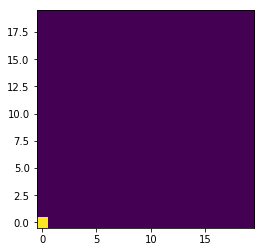

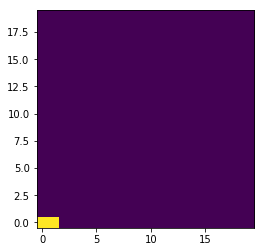

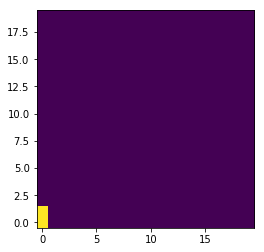

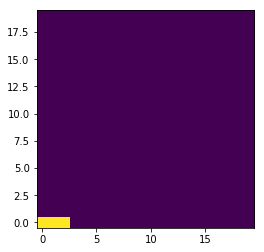

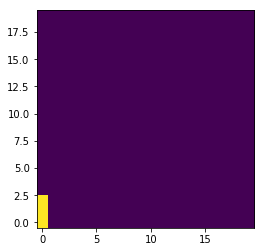

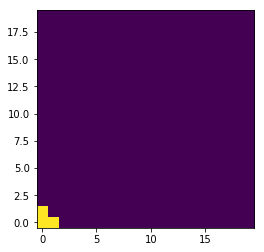

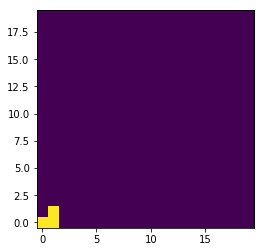

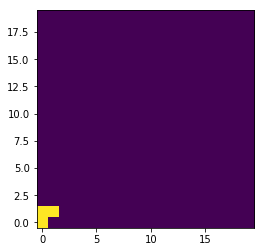

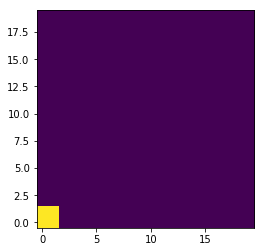

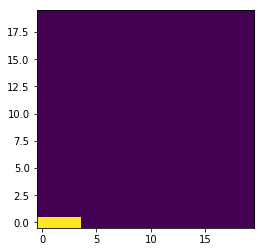

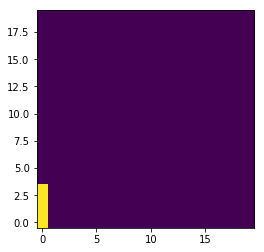

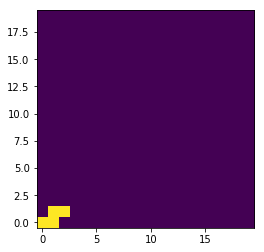

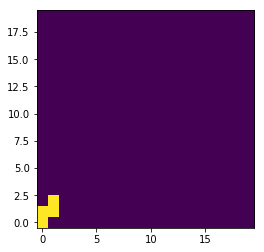

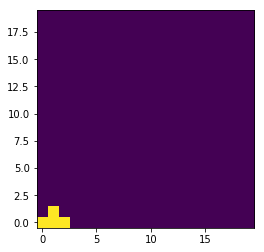

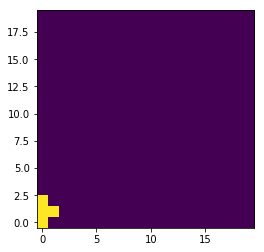

In [23]:
for move in board.players[0].valid_moves:
    board.visualize_move(move)

## Sandbox

In [ ]:
p1 = Piece([Point(0, 0)])
p2 = Piece([Point(0, 0), Point(0, 1)])
p3 = Piece([Point(0, 0), Point(0, 1), Point(0, 2)])
p4 = Piece([Point(0, 0), Point(0, 1), Point(1, 1)])
p5 = Piece([Point(0, 0), Point(1, 0), Point(0, 1), Point(1, 1)])
p6 = Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0)])
p7 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)])
p8 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 0)])

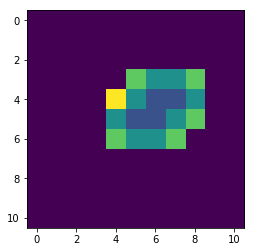

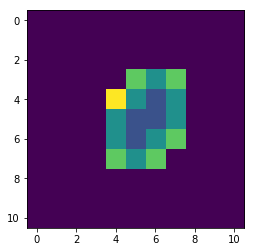

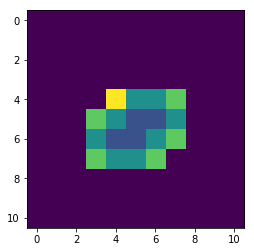

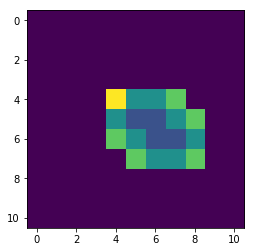

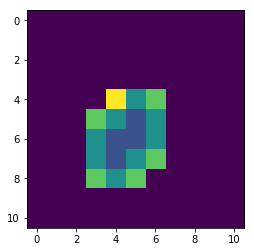

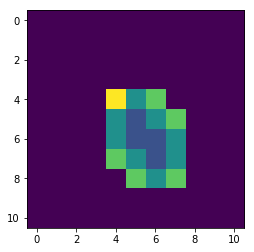

In [5]:
p = p7
vis = PieceVisualization()
for o in p.orientations:
    vis.display(o)